In [1]:
from resnet import *
from cifar_very_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [2]:
train_loader, test_loader, train_loader_no_augumentation = cifar10_loader(batch_size=128)


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch_num = 50
basic_results = [] # результаты без дистилляции. Каждый элемент списка - accuracy
resnet_results = [] # результаты с дистилляцией ResNet. Каждый элемент списка - кортеж вида (accuracy, beta, temp)
cnn_results = [] # результаты с дистилляцией CNN. Каждый элемент списка - кортеж вида (accuracy, beta, temp)

In [4]:
def accuracy(student):
        total = 0 
        correct = 0
        with t.no_grad():
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)
                out = student(x)
                correct += t.eq(t.argmax(out, 1), y).sum()
                total+=len(x)
        return (correct/total).cpu().detach().numpy()

In [5]:
# 5 запусков --- без дистилляции

In [6]:
for _ in range(5):
    student = Cifar_Very_Tiny(10).to(device)
    #optim = t.optim.Adam(student.parameters())
    optim = t.optim.SGD(student.parameters(), lr=0.001)
    crit = nn.CrossEntropyLoss()
    for _ in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for x,y in tq:
            x = x.to(device)
            y = y.to(device)
            student.zero_grad()
            out = student(x)
            loss = crit(student(x), y)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
    basic_results.append(accuracy(student))
    print ('accuracy', basic_results[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

accuracy 0.5424


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy 0.5517


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy 0.5378


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy 0.54179996


current loss:1.310115098953247: 100%|██████████| 391/391 [00:10<00:00, 36.48it/s]


accuracy 0.50879997


In [7]:
def distill(out, batch_logits, temp):
    sm = nn.Softmax(dim=1)
    g = sm(out/temp)
    f = sm(batch_logits/temp)
    kl = nn.KLDivLoss(reduction='batchmean')
    return kl(f, g)

In [12]:
# 20 запусков --- с ResNet
logits = np.load('./logits_resnet.npy')
for _ in range(20):
    beta = np.random.uniform()
    temp = 10**(np.random.uniform(low=-1, high=1)) # температура от 0.1 до 10
    print ('hyperparameters', beta, temp)
    student = Cifar_Very_Tiny(10).to(device)
    #optim = t.optim.Adam(student.parameters())
    optim = t.optim.SGD(student.parameters(), lr=0.001)
    crit = nn.CrossEntropyLoss()
    for _ in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for batch_id, (x,y) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device)            
            student.zero_grad()
            out = student(x)
            student_loss = crit(student(x), y)
            #distillation_loss = 0.0 # здесь твой код!
            distillation_loss = distill(out, batch_logits, temp)
            loss = (1-beta) * student_loss + beta*distillation_loss
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
    resnet_results.append((accuracy(student), beta, temp))
    print ('accuracy', resnet_results[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

hyperparameters 0.11958219685629079 0.17182169343405432


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.51199996, dtype=float32), 0.11958219685629079, 0.17182169343405432)
hyperparameters 0.7932574995506428 2.6571499396075287


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.3902, dtype=float32), 0.7932574995506428, 2.6571499396075287)
hyperparameters 0.9920685676830809 0.6343817086326983


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.2794, dtype=float32), 0.9920685676830809, 0.6343817086326983)
hyperparameters 0.7436227300342308 2.139444215767114


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.4201, dtype=float32), 0.7436227300342308, 2.139444215767114)
hyperparameters 0.5732453120378002 2.5671887944190748


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.43469998, dtype=float32), 0.5732453120378002, 2.5671887944190748)
hyperparameters 0.03930156523190198 4.140869457065747


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.55009997, dtype=float32), 0.03930156523190198, 4.140869457065747)
hyperparameters 0.7500580818687124 0.9828856557056701


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.4114, dtype=float32), 0.7500580818687124, 0.9828856557056701)
hyperparameters 0.10129593583806318 3.5658258086369043


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.53499997, dtype=float32), 0.10129593583806318, 3.5658258086369043)
hyperparameters 0.5928250619685678 1.7646429195182196


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.44869998, dtype=float32), 0.5928250619685678, 1.7646429195182196)
hyperparameters 0.04381179951812075 0.9081812206423826


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.5203, dtype=float32), 0.04381179951812075, 0.9081812206423826)
hyperparameters 0.16132921600620231 5.259476554867887


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.5216, dtype=float32), 0.16132921600620231, 5.259476554867887)
hyperparameters 0.5489897558452683 0.11909060341740987


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.33449998, dtype=float32), 0.5489897558452683, 0.11909060341740987)
hyperparameters 0.14405238895431893 0.9176800855999695


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.5493, dtype=float32), 0.14405238895431893, 0.9176800855999695)
hyperparameters 0.2966415123820938 0.6998974378114141


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.4894, dtype=float32), 0.2966415123820938, 0.6998974378114141)
hyperparameters 0.5591809580041471 6.929433578193837


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.4567, dtype=float32), 0.5591809580041471, 6.929433578193837)
hyperparameters 0.7708544429051166 0.1881820379132395


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.343, dtype=float32), 0.7708544429051166, 0.1881820379132395)
hyperparameters 0.2001505951088114 2.0082100955162296


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.5191, dtype=float32), 0.2001505951088114, 2.0082100955162296)
hyperparameters 0.8575734834141558 2.5363177272872863


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.3509, dtype=float32), 0.8575734834141558, 2.5363177272872863)
hyperparameters 0.08789189176403112 0.3030171051381871


  0%|          | 0/391 [00:00<?, ?it/s]

accuracy (array(0.525, dtype=float32), 0.08789189176403112, 0.3030171051381871)
hyperparameters 0.5389962357205916 1.85106538587003


current loss:-0.5404899716377258: 100%|██████████| 391/391 [00:11<00:00, 33.96it/s]


accuracy (array(0.45409998, dtype=float32), 0.5389962357205916, 1.85106538587003)


In [ ]:
# 20 запусков --- с CNN
logits = np.load('./logits_cnn.npy')
for _ in range(20):
    beta = np.random.uniform()
    temp = 10**(np.random.uniform(low=-1, high=1)) # температура от 0.1 до 10  
    print ('hyperparameters', beta, temp)
    student = Cifar_Very_Tiny(10).to(device)
    #optim = t.optim.Adam(student.parameters())
    optim = t.optim.SGD(student.parameters(), lr=0.001)
    crit = nn.CrossEntropyLoss()
    for _ in range(epoch_num):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []
        for batch_id, (x,y) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)            
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device)            
            student.zero_grad()
            out = student(x)
            student_loss = crit(student(x), y)
            #distillation_loss = 0.0 # здесь твой код!
            distillation_loss = distill(out, batch_logits, temp)
            loss = (1-beta) * student_loss + beta*distillation_loss
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
    cnn_results.append((accuracy(student), beta, temp))
    print ('accuracy', cnn_results[-1])

In [ ]:
# график, разрез beta-accuracy
plt.scatter([0]*len(basic_results), basic_results, c='r', label='Без дистилляции')
#plt.scatter([r[1] for r in cnn_results], [r[0] for r in cnn_results], c='r', marker='x', label='Дистилляция CNN')
plt.scatter([r[1] for r in resnet_results], [r[0] for r in resnet_results], c='r', marker='d', label='Дистилляция ResNet')
plt.legend(loc='best')
plt.xlabel('Beta')
plt.ylabel('Accuracy')
plt.savefig('scatter_beta_acc.png')

In [ ]:
# график, разрез accuracy-Temp
plt.scatter([0.0]*len(basic_results), basic_results, c='r', label='Без дистилляции')
#plt.scatter([np.log10(r[2]) for r in cnn_results], [r[0] for r in cnn_results], c='r', marker='x', label='Дистилляция CNN')
plt.scatter([np.log10(r[2]) for r in resnet_results], [r[0] for r in resnet_results], c='r', marker='d', label='Дистилляция ResNet')
plt.legend(loc='best')
plt.xlabel('log(T)')
plt.ylabel('Accuracy')
plt.savefig('scatter_temp_acc.png')

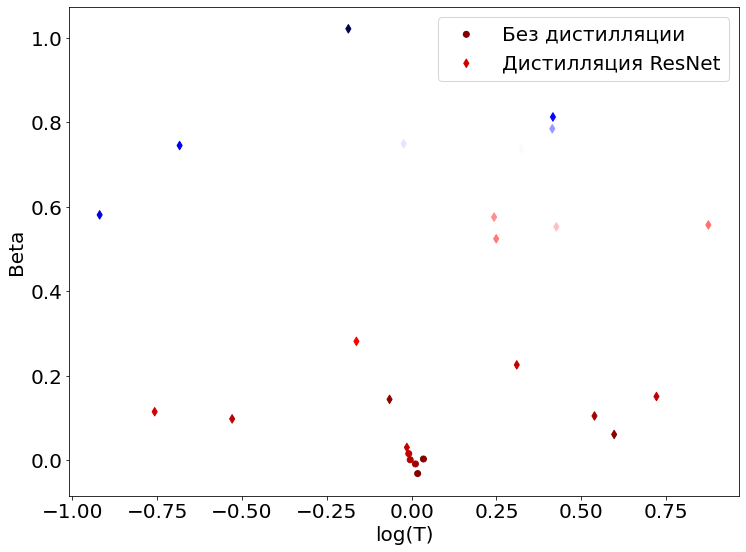

In [16]:
# график, разрез Temp-beta. Цвет --- точность относительно всех результатов

# для резульатов без дистилляции у нас будут повторяющиеся точки. 
# обычно в таком случае в график вносят небольшой шум, чтобы точки можно было визуально различить
eps = 0.02 

all_results = basic_results+[r[0] for r in cnn_results] + [r[0] for r in resnet_results]
max_ = np.max(all_results)
min_ = np.min(all_results)
colors = [cm.seismic((r-min_)/(max_-min_)) for r in basic_results]
plt.scatter(np.random.randn(len(basic_results))*eps, np.random.randn(len(basic_results))*eps, c=colors, label='Без дистилляции')
#colors = [cm.seismic((r[0]-min_)/(max_-min_)) for r in cnn_results]
#plt.scatter([np.log10(r[2]) + np.random.randn()*eps for r in cnn_results], [r[1] + np.random.randn()*eps for r in cnn_results], c=colors, marker='x', label='Дистилляция CNN')
colors = [cm.seismic((r[0]-min_)/(max_-min_)) for r in resnet_results]
plt.scatter([np.log10(r[2]) + np.random.randn()*eps for r in resnet_results], [r[1] + np.random.randn()*eps for r in resnet_results], c=colors, marker='d', label='Дистилляция ResNet')
plt.legend(loc='best')
plt.xlabel('log(T)')
plt.ylabel('Beta')
plt.savefig('scatter_temp_beta.png')